In [1]:
# 필요 라이브러리 임포트

import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import urllib3
import matplotlib.pyplot as plt

tf.config.list_physical_devices('GPU')
urllib3.disable_warnings()

tfds.disable_progress_bar()

In [2]:
# 데이터셋 다운로드
# tfds.load()는 기본적으로 ~/tensorflow_datasets 경로에 데이터셋을 다운
# 데이터셋 경로를 바꾸고 싶으시다면, data_dir 인자를 사용

(ds_train, ds_test), ds_info = tfds.load('cifar10', split = ['train', 'test'], shuffle_files = True, with_info = True)

In [3]:
# 다운받은 데이터셋 feature 정보 확인

print(ds_info.features)

FeaturesDict({
    'id': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})


In [4]:
# 데이터의 개수 확인
# tensorflow 데이터셋은 numpy 가 아니기 때문에 ds_train.shape로 확인하지 않는다.

print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(50000, shape=(), dtype=int64)
tf.Tensor(10000, shape=(), dtype=int64)


In [5]:
# input normalization
# 각 채널별 최대값인 255로 정규화

def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    # image = tf.image.resize(image, [32, 32])
    return tf.cast(image, tf.float32) / 255., label

def apply_normalize_on_dataset(ds, is_test = False, batch_size = 16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [6]:
# CIFAR - 10 이 가지는 클래스 수 및 클래스명 확인

ds_info.features['label'].num_classes

10

In [7]:
ds_info.features['label'].names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

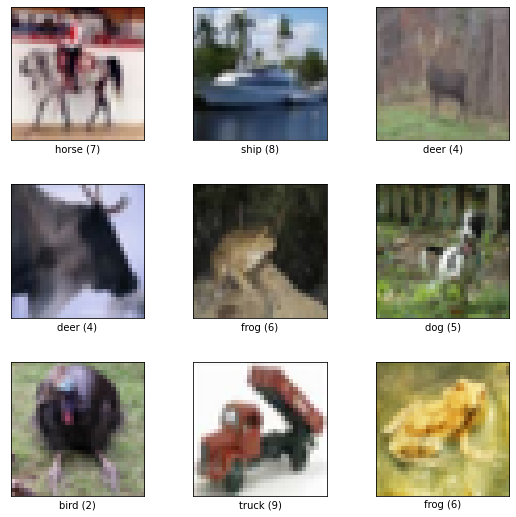

In [8]:
fig = tfds.show_examples(ds_train, ds_info)

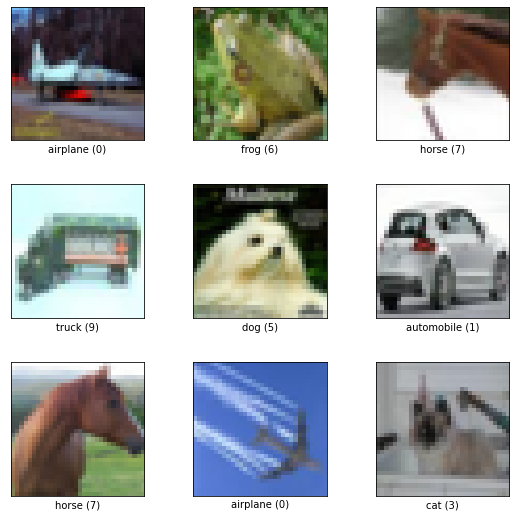

In [9]:
fig = tfds.show_examples(ds_test, ds_info)


In [10]:
# VGG 블록 구성

def build_vgg_block(input_layer, num_cnn = 3, channel = 64, block_num = 1) : 
    x = input_layer    # 입력 레이어
    
    # CNN 레이어
    for cnn_num in range(num_cnn) : 
        x = keras.layers.Conv2D(filters = channel, kernel_size = (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same', name = f'block{block_num}_conv{cnn_num}')(x)
    
    # MaxPooling 레이어
    x = keras.layers.MaxPooling2D(pool_size = (2, 2), strides = 2, name = f'block{block_num}_pooling')(x)
    
    return x

In [11]:
# VGG 블록을 추가하는 함수를 통해 input_layer 에 추가
# 입력 레이어를 인자로 building_vgg_block() 블록의 레이어를 build, 출력
# keras 의 Model 클래스에서 input 과 output 을 정의함으로 블록의 모델 확인

# 입력 레이어 생성
vgg_input_layer = keras.layers.Input(shape = (32, 32, 3))

# VGG 블록 생성
vgg_block_output = build_vgg_block(vgg_input_layer)

In [12]:
# 블록 1개짜리 model 생성

model = keras.Model(inputs = vgg_input_layer, outputs = vgg_block_output)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pooling (MaxPooling2D (None, 16, 16, 64)        0         
Total params: 75,648
Trainable params: 75,648
Non-trainable params: 0
_________________________________________________________________


In [13]:
# VGG - 16 모델 생성

def build_vgg(input_shape = (32, 32, 3), num_cnn_list = [2, 2, 3, 3, 3], channel_list = [64, 128, 256, 512, 512], num_classes = 10) : 
    assert len(num_cnn_list) == len(channel_list)    # 모델을 만들기 전에 config list 들이 같은 길이인지 확인
    
    input_layer = keras.layers.Input(shape = input_shape)    # input layer 를 생성
    output = input_layer
    
    # config list 들의 길이만큼 반복하면서 블록 생성
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)) : 
        output = build_vgg_block(output, num_cnn = num_cnn, channel = channel, block_num = i)
        
    output = keras.layers.Flatten(name = 'flatten')(output)
    output = keras.layers.Dense(4096, activation = 'relu', name = 'fc1')(output)
    output = keras.layers.Dense(4096, activation = 'relu', name = 'fc2')(output)
    output = keras.layers.Dense(num_classes, activation = 'softmax', name = 'predictions')(output)
    
    model = keras.Model(inputs = input_layer, outputs = output)
    
    return model

In [14]:
# 기본값을 사용해 VGG 모델을 만들면 VGG - 16 모델 생성 완료

vgg_16 = build_vgg()

vgg_16.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block0_conv0 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block0_conv1 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block0_pooling (MaxPooling2D (None, 16, 16, 64)        0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block1_pooling (MaxPooling2D (None, 8, 8, 128)         0   

In [15]:
# VGG - 16 구성 변경을 통한 VGG - 19 생성

# 원하는 블록의 설계에 따라 매개변수로 리스트를 전달
vgg_19 = build_vgg(num_cnn_list = [2, 2, 4, 4, 4], channel_list = [64, 128, 256, 512, 512])

vgg_19.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block0_conv0 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block0_conv1 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block0_pooling (MaxPooling2D (None, 16, 16, 64)        0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block1_pooling (MaxPooling2D (None, 8, 8, 128)         0   

In [16]:
# VGG - 16 과 VGG - 19 비교

BATCH_SIZE = 256
EPOCH = 40

In [17]:
# CIFAR - 10 데이터셋 불러오기

(ds_train, ds_test), ds_info = tfds.load('cifar10', split = ['train', 'test'], as_supervised = True, shuffle_files = True, with_info = True)

ds_train = apply_normalize_on_dataset(ds_train, batch_size = BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size = BATCH_SIZE)

In [18]:
vgg_16.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = tf.keras.optimizers.SGD(lr = 0.01, clipnorm = 1.),
    metrics = ['accuracy']
)

history_16 = vgg_16.fit(
    ds_train,
    steps_per_epoch = int(ds_info.splits['train'].num_examples / BATCH_SIZE),
    validation_steps = int(ds_info.splits['test'].num_examples / BATCH_SIZE),
    epochs = EPOCH,
    validation_data = ds_test,
    verbose = 1,
    use_multiprocessing = True,
)

Epoch 1/40
195/195 [==============================] - 47s 243ms/step - loss: 2.1656 - accuracy: 0.2031 - val_loss: 2.0875 - val_accuracy: 0.2486
Epoch 2/40
195/195 [==============================] - 17s 85ms/step - loss: 1.9788 - accuracy: 0.2889 - val_loss: 1.8784 - val_accuracy: 0.3453
Epoch 3/40
195/195 [==============================] - 17s 85ms/step - loss: 1.8422 - accuracy: 0.3446 - val_loss: 1.7935 - val_accuracy: 0.3504
Epoch 4/40
195/195 [==============================] - 17s 87ms/step - loss: 1.7475 - accuracy: 0.3736 - val_loss: 1.7231 - val_accuracy: 0.3836
Epoch 5/40
195/195 [==============================] - 17s 89ms/step - loss: 1.6783 - accuracy: 0.4008 - val_loss: 1.6456 - val_accuracy: 0.4038
Epoch 6/40
195/195 [==============================] - 18s 91ms/step - loss: 1.6244 - accuracy: 0.4212 - val_loss: 1.5958 - val_accuracy: 0.4139
Epoch 7/40
195/195 [==============================] - 17s 88ms/step - loss: 1.5668 - accuracy: 0.4380 - val_loss: 1.5338 - val_accuracy

In [19]:
# VGG - 19 모델 생성 및 훈련

vgg_19.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = tf.keras.optimizers.SGD(lr = 0.01, clipnorm = 1.),
    metrics = ['accuracy'],
)

history_19 = vgg_19.fit(
    ds_train,
    steps_per_epoch = int(ds_info.splits['train'].num_examples / BATCH_SIZE),
    validation_steps = int(ds_info.splits['test'].num_examples / BATCH_SIZE),
    epochs = EPOCH,
    validation_data = ds_test,
    verbose = 1,
    use_multiprocessing = True,
)

Epoch 1/40
195/195 [==============================] - 20s 105ms/step - loss: 2.2304 - accuracy: 0.1699 - val_loss: 2.1084 - val_accuracy: 0.2498
Epoch 2/40
195/195 [==============================] - 20s 105ms/step - loss: 2.0440 - accuracy: 0.2525 - val_loss: 1.9637 - val_accuracy: 0.3031
Epoch 3/40
195/195 [==============================] - 20s 105ms/step - loss: 1.9066 - accuracy: 0.3096 - val_loss: 1.8190 - val_accuracy: 0.3426
Epoch 4/40
195/195 [==============================] - 20s 105ms/step - loss: 1.7869 - accuracy: 0.3585 - val_loss: 1.7430 - val_accuracy: 0.3782
Epoch 5/40
195/195 [==============================] - 20s 105ms/step - loss: 1.7032 - accuracy: 0.3852 - val_loss: 1.6409 - val_accuracy: 0.3933
Epoch 6/40
195/195 [==============================] - 20s 105ms/step - loss: 1.6364 - accuracy: 0.4093 - val_loss: 1.6064 - val_accuracy: 0.4053
Epoch 7/40
195/195 [==============================] - 20s 105ms/step - loss: 1.5702 - accuracy: 0.4324 - val_loss: 1.5948 - val_ac

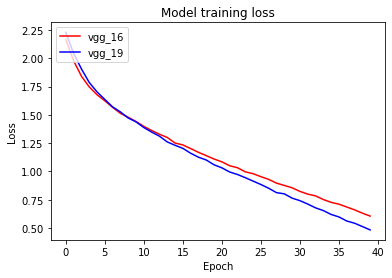

In [20]:
# VGG - 16, VGG - 19 의 학습과정을 그래프로 시각화
# training loss 과정을 확인

plt.plot(history_16.history['loss'], 'r')
plt.plot(history_19.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['vgg_16', 'vgg_19'], loc='upper left')
plt.show()

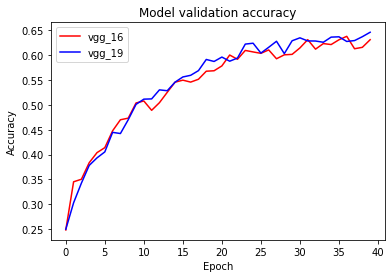

In [21]:
# VGG - 16 과 VGG - 19 이검증 정확도 (validation acuuracy) 비교

plt.plot(history_16.history['val_accuracy'], 'r')
plt.plot(history_19.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['vgg_16', 'vgg_19'], loc='upper left')
plt.show()